In [1]:
# devtools::install_github("maxbiostat/phylodyn", ref = "pc_prior")

In [2]:
library(phylodyn)
library(ape)

In [3]:
Trees.A <- list(
    seed1 = read.nexus("~/DUMP/fmdv/temporal_only/mcc_seed_1_serotype_A_VP1.tree"),
    seed2 = read.nexus("~/DUMP/fmdv/temporal_only/mcc_seed_2_serotype_A_VP1.tree"),
    seed3 = read.nexus("~/DUMP/fmdv/temporal_only/mcc_seed_3_serotype_A_VP1.tree")
)

In [4]:
Trees.O <- list(
    seed1 = read.nexus("~/DUMP/fmdv/temporal_only/mcc_seed_1_serotype_O_VP1.tree"),
    seed2 = read.nexus("~/DUMP/fmdv/temporal_only/mcc_seed_2_serotype_O_VP1.tree"),
    seed3 = read.nexus("~/DUMP/fmdv/temporal_only/mcc_seed_3_serotype_O_VP1.tree")
)

In [5]:
fmd.temporal <- read.csv("../../DATA//EPI_DATA/temporal_predictors.csv")

In [6]:
head(fmd.temporal)

Year,production_Cattle,production_Goats,production_Horses,production_Pigs,production_Sheep,doses,doses_dispersion,trade_cattle,trade_goats,trade_pigs,trade_sheep,trade_horses,cases_A,cases_O
1961,144273652,18655245,12231892,38296668,117770156,NA,NA,NA,NA,NA,NA,NA,NA,NA
1962,146876252,18916453,12072125,37933537,116188552,NA,NA,NA,NA,NA,NA,NA,NA,NA
1963,146156904,19531088,12112003,38820329,115267578,NA,NA,NA,NA,NA,NA,NA,NA,NA
1964,150950602,19503888,12254550,39923109,115885379,NA,NA,NA,NA,NA,NA,NA,NA,NA
1965,157663259,19665095,12303322,40844509,118891981,NA,NA,NA,NA,NA,NA,NA,NA,NA
1966,163031732,19820407,12428456,41795809,119793416,NA,NA,NA,NA,NA,NA,NA,NA,NA


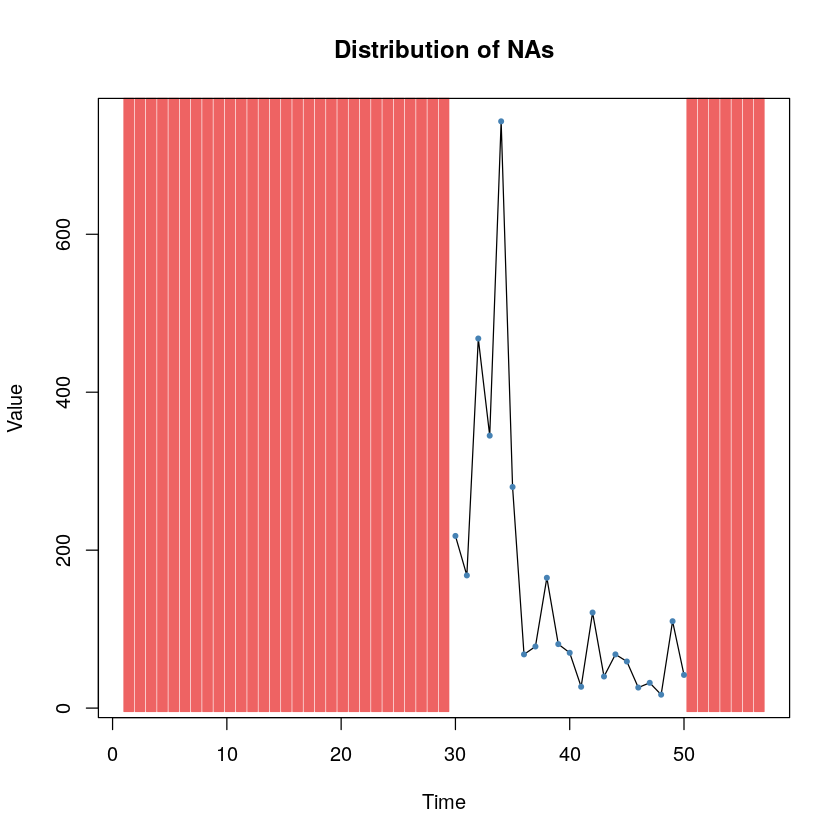

In [7]:
imputeTS::plotNA.distribution(ts(fmd.temporal$cases_O))

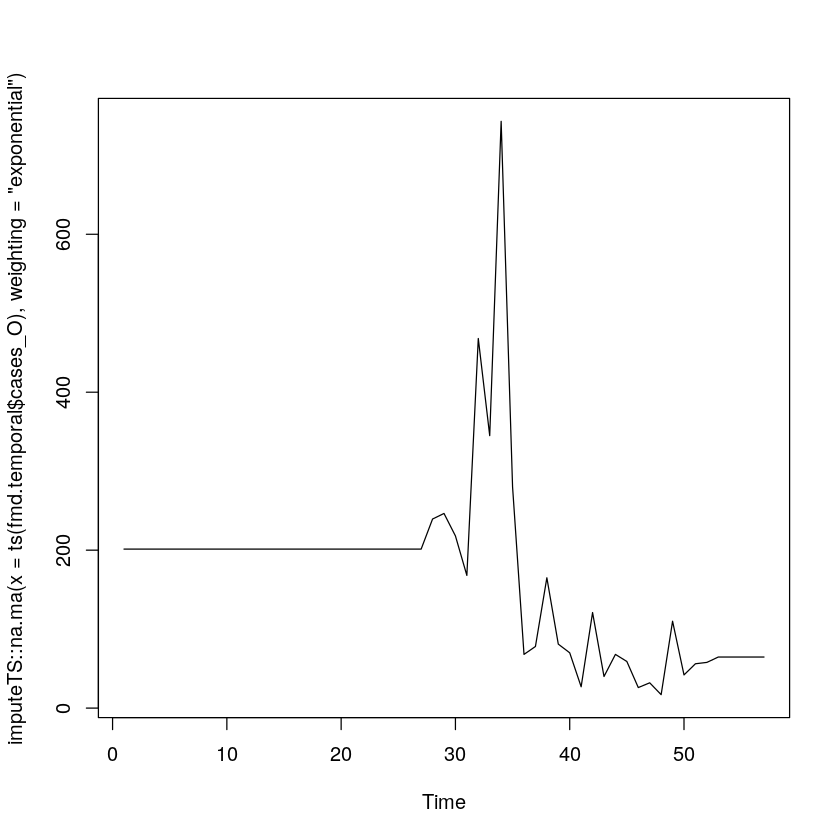

In [8]:
plot(imputeTS::na.ma(x = ts(fmd.temporal$cases_O), weighting = "exponential"))

In [9]:
library(mgcv)

Loading required package: nlme
This is mgcv 1.8-24. For overview type 'help("mgcv-package")'.


In [10]:
fmd.temporal$scaled_Year <- max(fmd.temporal$Year) - fmd.temporal$Year

In [11]:
m.casesO <- gam( cases_O ~ s(scaled_Year), family = "negbin(3)",   data = fmd.temporal)

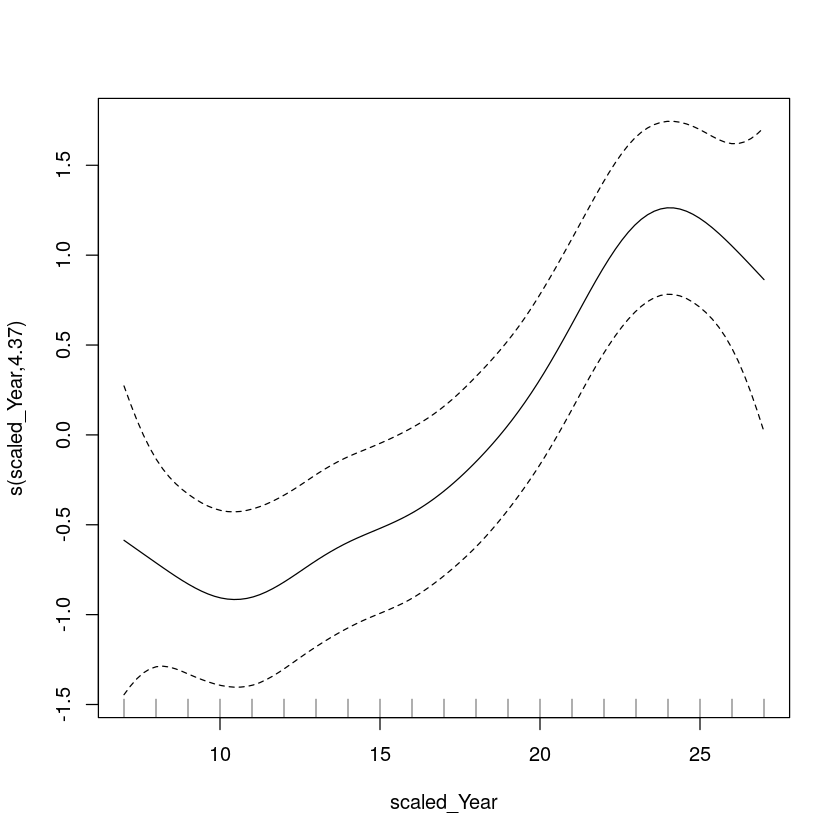

In [12]:
plot(m.casesO)
points(cases_O ~ Year, data = fmd.temporal)
case_fn <- function(t){
    pred <- predict(m.casesO, newdata = data.frame(scaled_Year = t) , type = "response")
    return( as.numeric(pred) )
}

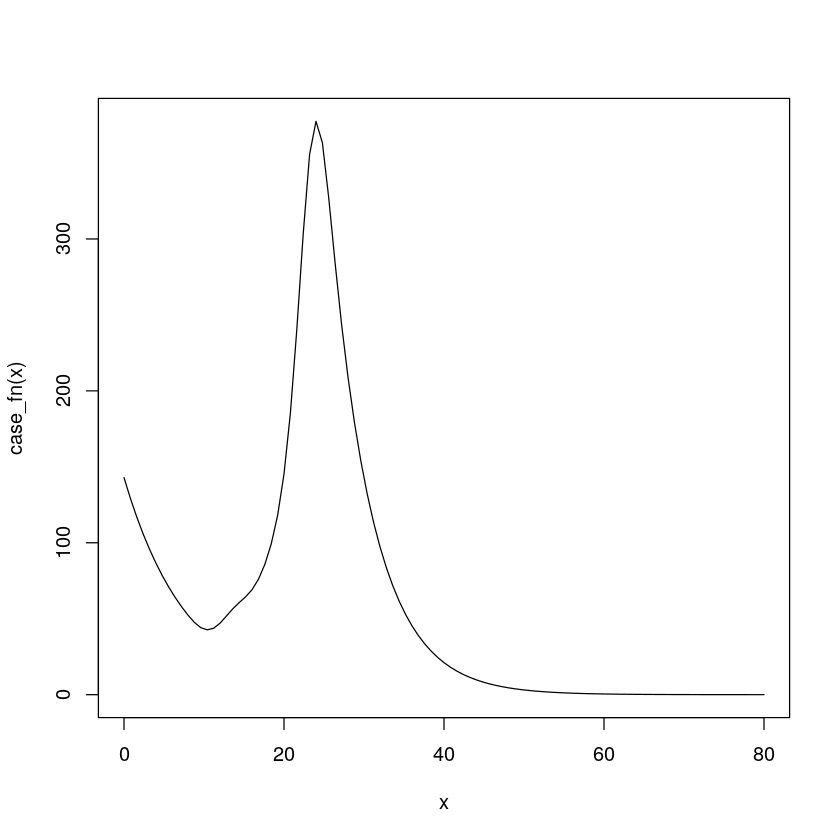

In [13]:
curve(case_fn, 0, 80)

In [14]:
get_reconstructions_cov <- function(tree){
    out <- list(
        naive = phylodyn::BNPR(data = tree, lengthout = 100, pc_prior = TRUE),
        preferential = phylodyn::BNPR_PS(data = tree, lengthout = 100, pc_prior = TRUE),
        preferential_cov = phylodyn::BNPR_PS(data = tree,
                                         fns = list(f1 = function(t) t),
                                             lengthout = 100, pc_prior = TRUE)
    ) 
    return(out)
}

In [15]:
reconstructions.A <- lapply(Trees.A, get_reconstructions_cov)

In [16]:
reconstructions.O <- lapply(Trees.O, get_reconstructions_cov)

In [17]:
plot_reconstructions <- function(recons, times, verbose = FALSE){
    par(mfrow = c(1, 3))
    ymax <- max( c( max(recons$naive$effpop975),
                   max(recons$preferential$effpop975),
                   max(recons$preferential_cov$effpop975) ))
    if(verbose) cat("max y:", ymax, "\n")
    plot_BNPR(recons$naive, xlab = "Time (years)", axlabs = times,
              ylim = c(0.5, ymax),
              main = "Naive")
    plot_BNPR(recons$preferential, xlab = "Time (years)", axlabs = times,
              ylim = c(0.5, ymax),
              main = "Accounting for sampling")
    plot_BNPR(recons$preferential_cov, xlab = "Time (years)", axlabs = times,
              ylim = c(0.5, ymax),
              main = "Accounting for sampling and time")    
}

In [18]:
tt.A <- list(
    x = c(0, 20, 40, 60, 80),
    labs = as.character(2013 - c(0, 20, 40, 60, 80))
)
tt.O <- list(
    x = c(0, 20, 40, 60, 80),
    labs = as.character(2011 - c(0, 20, 40, 60, 80))
)

In [19]:
options(repr.plot.width = 10, repr.plot.height = 5)

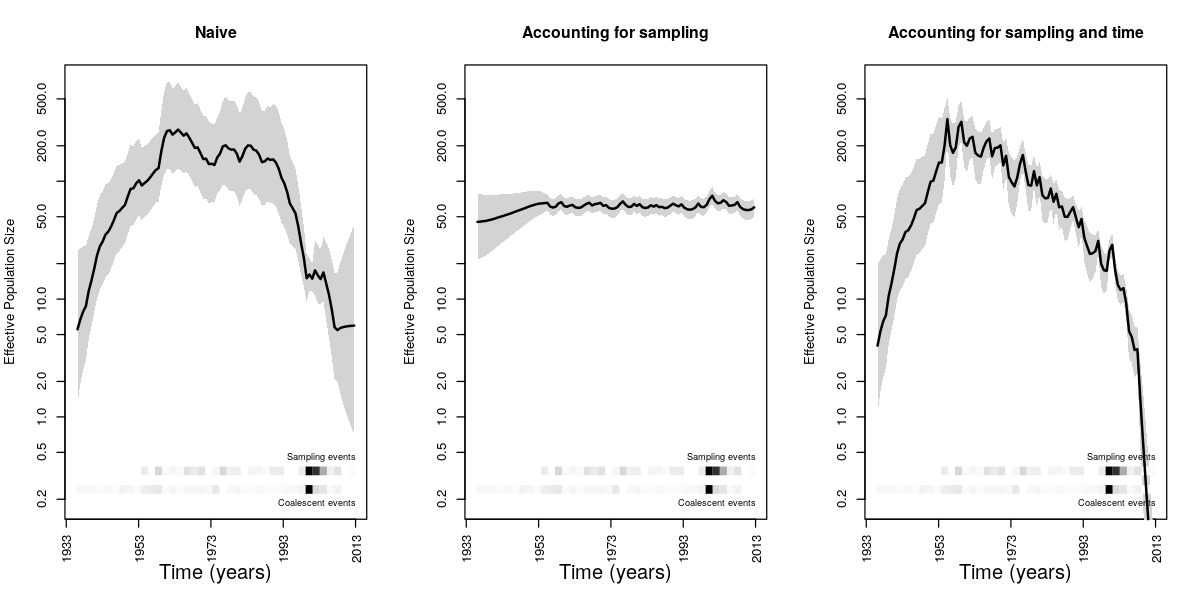

In [20]:
plot_reconstructions(reconstructions.A[[1]], times = tt.A)

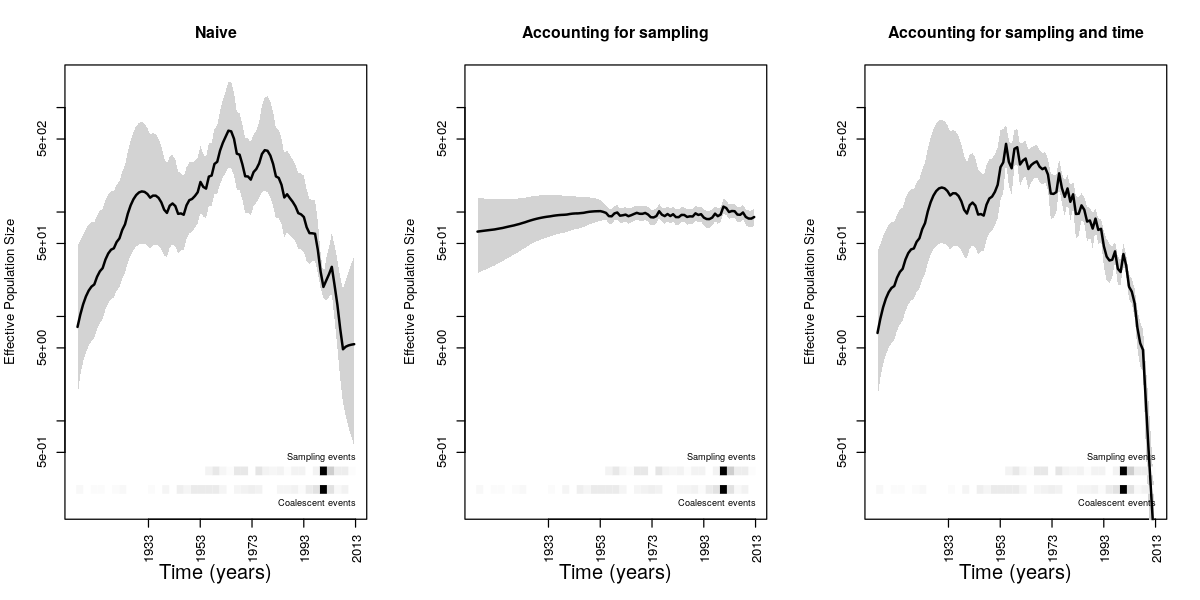

In [21]:
plot_reconstructions(reconstructions.A[[2]], times = tt.A)

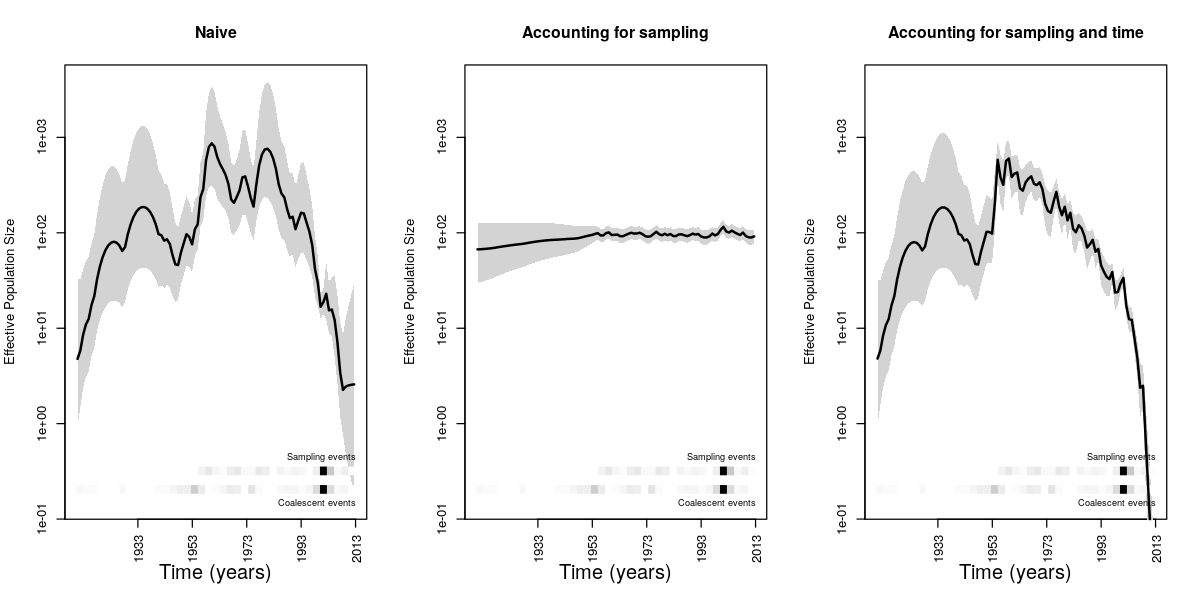

In [22]:
plot_reconstructions(reconstructions.A[[3]], times = tt.A)

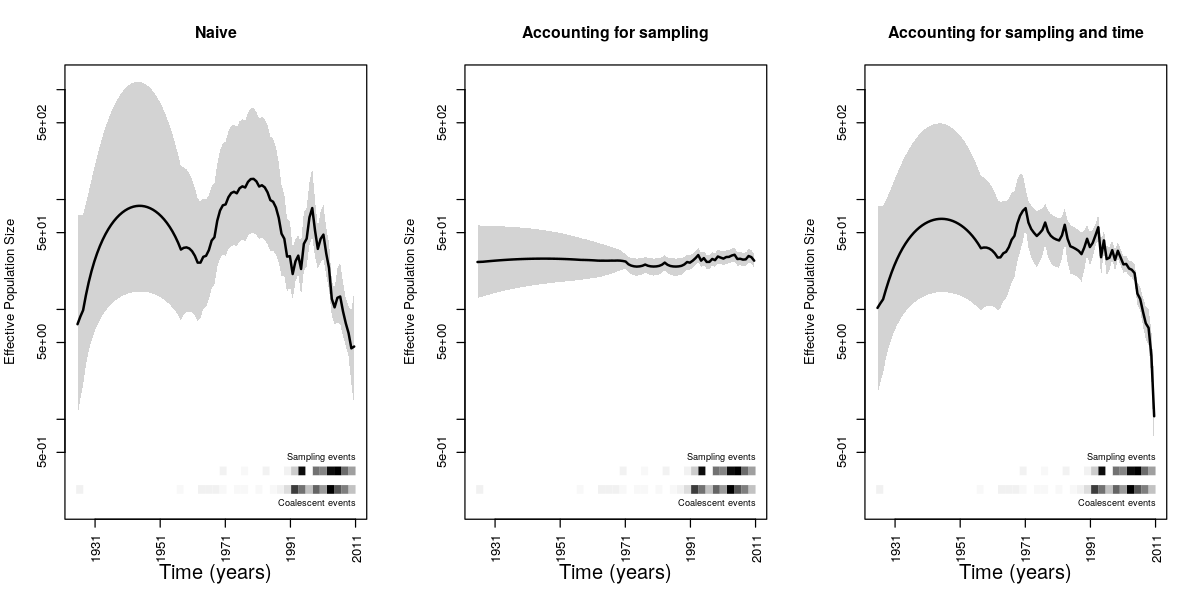

In [23]:
plot_reconstructions(reconstructions.O[[1]], times = tt.O)

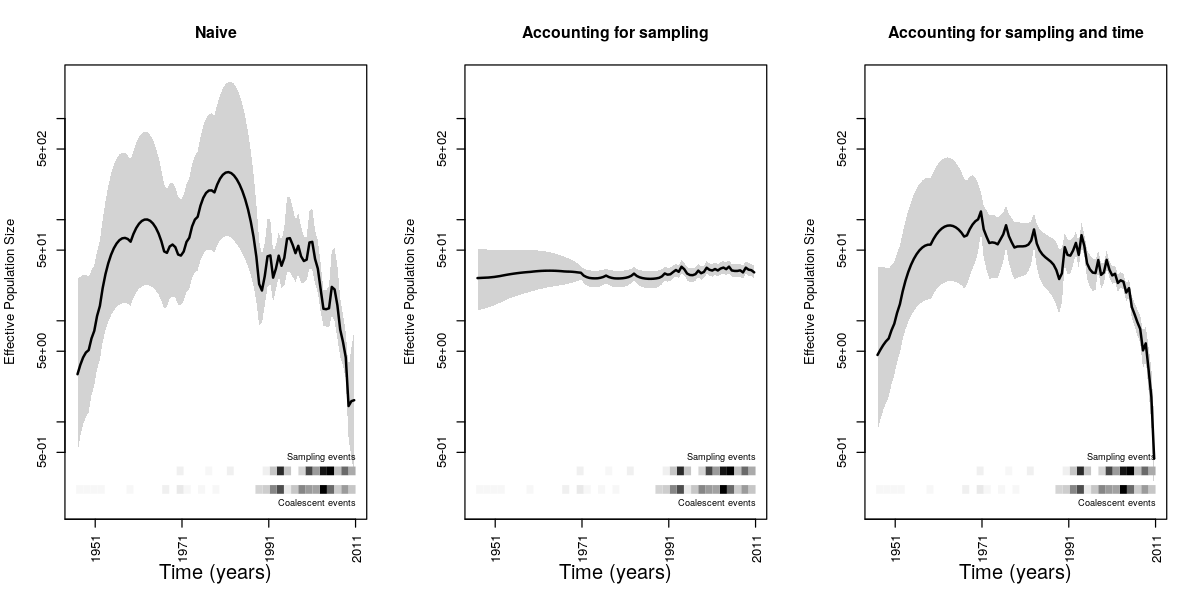

In [24]:
plot_reconstructions(reconstructions.O[[2]], times = tt.O)

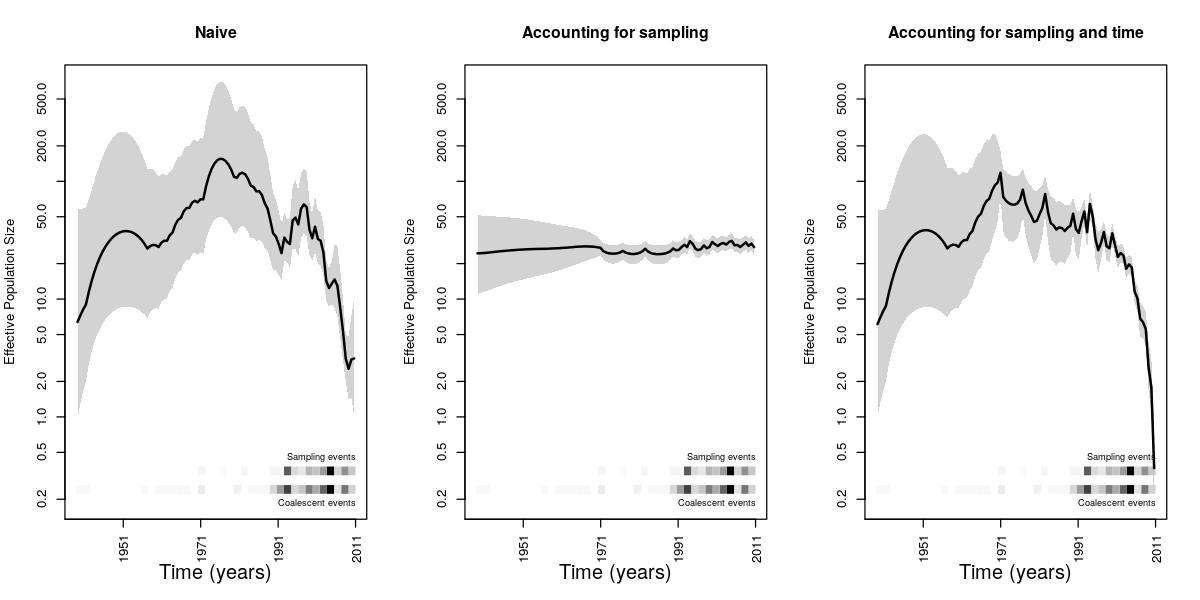

In [25]:
plot_reconstructions(reconstructions.O[[3]], times = tt.O)

In [26]:
plot_reconstructions_overlay <- function(recons, times){
    plot_BNPR(recons$naive, xlab = "Time (years)",
              axlabs = times, col = "blue", credible_region = FALSE)
    plot_BNPR(recons$preferential_cov, xlab = "Time (years)",
              axlabs = times, col = "red", newplot = FALSE, credible_region = FALSE)    
}

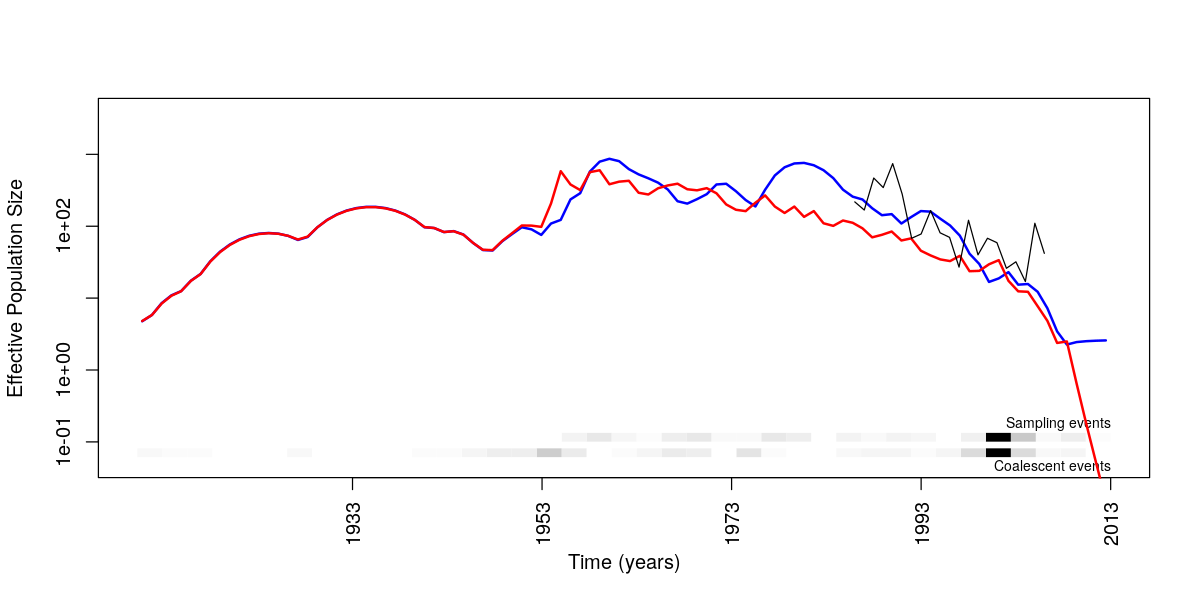

In [27]:
plot_reconstructions_overlay(reconstructions.A[[3]], times = tt.A)
lines(fmd.temporal$scaled_Year, fmd.temporal$cases_O)

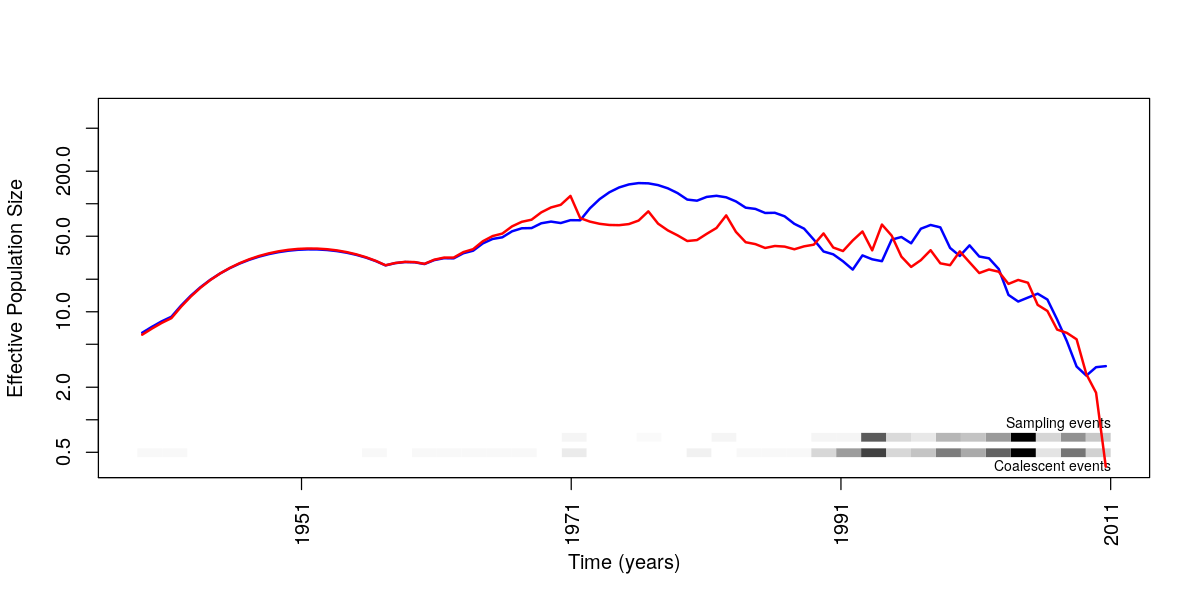

In [28]:
plot_reconstructions_overlay(reconstructions.O[[3]], times = tt.O)

In [29]:
summary( reconstructions.A[[1]]$naive$result )


Call:
c("INLA::inla(formula = formula, family = family, data = data, offset = data$E_log, ",  "    lincomb = lc_many, control.predictor = list(compute = TRUE), ",  "    control.inla = list(lincomb.derived.only = FALSE))")

Time used:
 Pre-processing    Running inla Post-processing           Total 
         0.3892          0.5779          0.0331          1.0002 

The model has no fixed effects

Random effects:
Name	  Model
 time   RW1 model 

Model hyperparameters:
                    mean    sd 0.025quant 0.5quant 0.975quant  mode
Precision for time 7.536 3.678      2.764    6.756      16.83 5.422

Expected number of effective parameters(std dev): 17.83(3.798)
Number of equivalent replicates : 5.607 

Marginal log-Likelihood:  -158.89 
Posterior marginals for linear predictor and fitted values computed


In [30]:
summary( reconstructions.A[[1]]$preferential$result )


Call:
c("INLA::inla(formula = formula, family = family, data = data, offset = data$E_log, ",  "    lincomb = lc_many, control.predictor = list(compute = TRUE), ",  "    control.inla = list(lincomb.derived.only = FALSE))")

Time used:
 Pre-processing    Running inla Post-processing           Total 
         0.2197          3.6199          0.0458          3.8854 

Fixed effects:
          mean      sd 0.025quant 0.5quant 0.975quant     mode    kld
beta0 -91.6096 19.6139  -129.6697 -92.0953    -54.894 -55.5307 0.0358

Random effects:
Name	  Model
 time   RW1 model 
time2   Copy 

Model hyperparameters:
                     mean     sd 0.025quant 0.5quant 0.975quant   mode
Precision for time 219.77 82.420      99.31   206.36     418.69 181.62
Beta for time2      22.33  3.863      14.75    22.33      29.90  22.33

Expected number of effective parameters(std dev): 43.58(3.512)
Number of equivalent replicates : 4.016 

Marginal log-Likelihood:  -431.94 
Posterior marginals for linear predict

In [31]:
summary( reconstructions.A[[1]]$preferential_cov$result )


Call:
c("INLA::inla(formula = formula, family = family, data = data, offset = data$E_log, ",  "    lincomb = lc_many, control.predictor = list(compute = TRUE), ",  "    control.inla = list(lincomb.derived.only = FALSE))")

Time used:
 Pre-processing    Running inla Post-processing           Total 
         0.1655          0.8287          0.0607          1.0549 

Fixed effects:
          mean     sd 0.025quant 0.5quant 0.975quant     mode   kld
beta0  13.0408 2.8878     7.6500  12.9244    19.0789  12.6911 2e-04
fn    -12.4650 1.9747   -16.8678 -12.2769    -9.1393 -12.0278 1e-03

Random effects:
Name	  Model
 time   RW1 model 
time2   Copy 

Model hyperparameters:
                    mean    sd 0.025quant 0.5quant 0.975quant  mode
Precision for time 4.710 1.232      2.843    4.520      7.646 4.156
Beta for time2     6.713 1.057      4.863    6.622      8.993 6.291

Expected number of effective parameters(std dev): 60.07(2.307)
Number of equivalent replicates : 2.913 

Marginal log-Likel

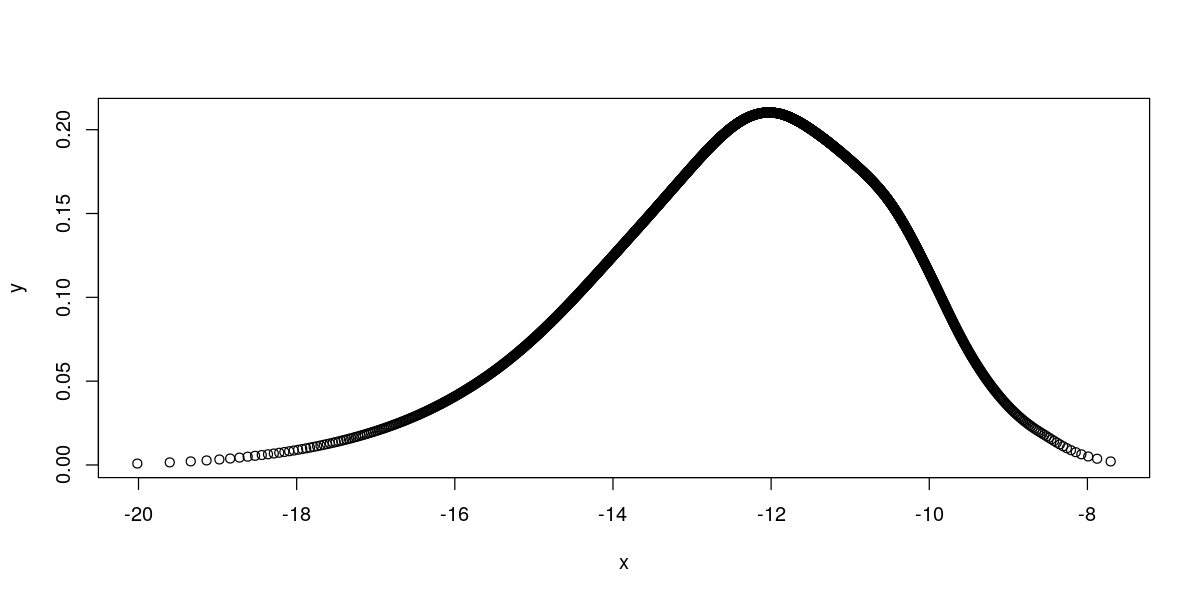

In [32]:
plot(INLA::inla.tmarginal(function(x) x, reconstructions.A[[1]]$preferential_cov$result$marginals.fixed[[2]]) )

## Preparing pub-ready figure

In [56]:
naive.A <- data.frame(
   time = rev(seq(2013-80, 2013, length.out = 100)),
   median = reconstructions.A$seed1$naive$effpop,
   lwr = reconstructions.A$seed1$naive$effpop025,
   upr = reconstructions.A$seed1$naive$effpop975
)
naive.A$serotype <- "A"
naive.A$method <- "Naive"

In [57]:
sampAware.A <- data.frame(
   time = rev(seq(2013-80, 2013, length.out = 100)),
   median = reconstructions.A$seed1$preferential_cov$effpop,
   lwr = reconstructions.A$seed1$preferential_cov$effpop025,
   upr = reconstructions.A$seed1$preferential_cov$effpop975
)
sampAware.A$serotype <- "A"
sampAware.A$method <- "Sampling+Covariate"

In [58]:
naive.O <- data.frame(
   time = rev(seq(2011-80, 2011, length.out = 100)),
   median = reconstructions.O$seed1$naive$effpop,
   lwr = reconstructions.O$seed1$naive$effpop025,
   upr = reconstructions.O$seed1$naive$effpop975
)
naive.O$serotype <- "O"
naive.O$method <- "Naive"

In [59]:
sampAware.O <- data.frame(
   time = rev(seq(2013-80, 2013, length.out = 100)),
   median = reconstructions.O$seed1$preferential_cov$effpop,
   lwr = reconstructions.O$seed1$preferential_cov$effpop025,
   upr = reconstructions.O$seed1$preferential_cov$effpop975
)
sampAware.O$serotype <- "O"
sampAware.O$method <- "Sampling+Covariate"

In [60]:
FMDV_effpop <- rbind(
    naive.A,
    naive.O,
    sampAware.A,
    sampAware.O
)

In [61]:
library(ggplot2)

In [71]:
cases.A <- data.frame(
    time = fmd.temporal$Year,
    cases = fmd.temporal$cases_A
)
cases.A$serotype <- "A"
cases.O <- data.frame(
    time = fmd.temporal$Year,
    cases = fmd.temporal$cases_O
)
cases.O$serotype <- "O"
all.cases <- rbind(cases.A, cases.O)

In [166]:
options(repr.plot.width = 12, repr.plot.height = 6)

In [167]:
p <- ggplot(data = subset(FMDV_effpop), aes(x = time, y = median,
                                                         colour = serotype, fill = serotype)) +
    geom_line(size = 1.1) +
    geom_ribbon(aes(ymin = lwr, ymax = upr), alpha = .4) +
    facet_grid(.~method) +
#     geom_line(data = all.cases, size = 1.2,
#              mapping = aes(x = time, y = cases)) + 
    scale_x_continuous("Time (years)", expand = c(0, 0)) +
    scale_y_log10(" (log) Effective population size", expand = c(0, 0)) +
    theme_bw(base_size = 20) +
    theme(panel.spacing.x=unit(1.5, "lines")) +
    scale_colour_manual(values=c("cadetblue", "indianred")) +
    scale_fill_manual(values=c("cadetblue", "indianred")) +
    guides(shape = guide_legend(override.aes = list(size = 3, alpha = 1))) +
NULL

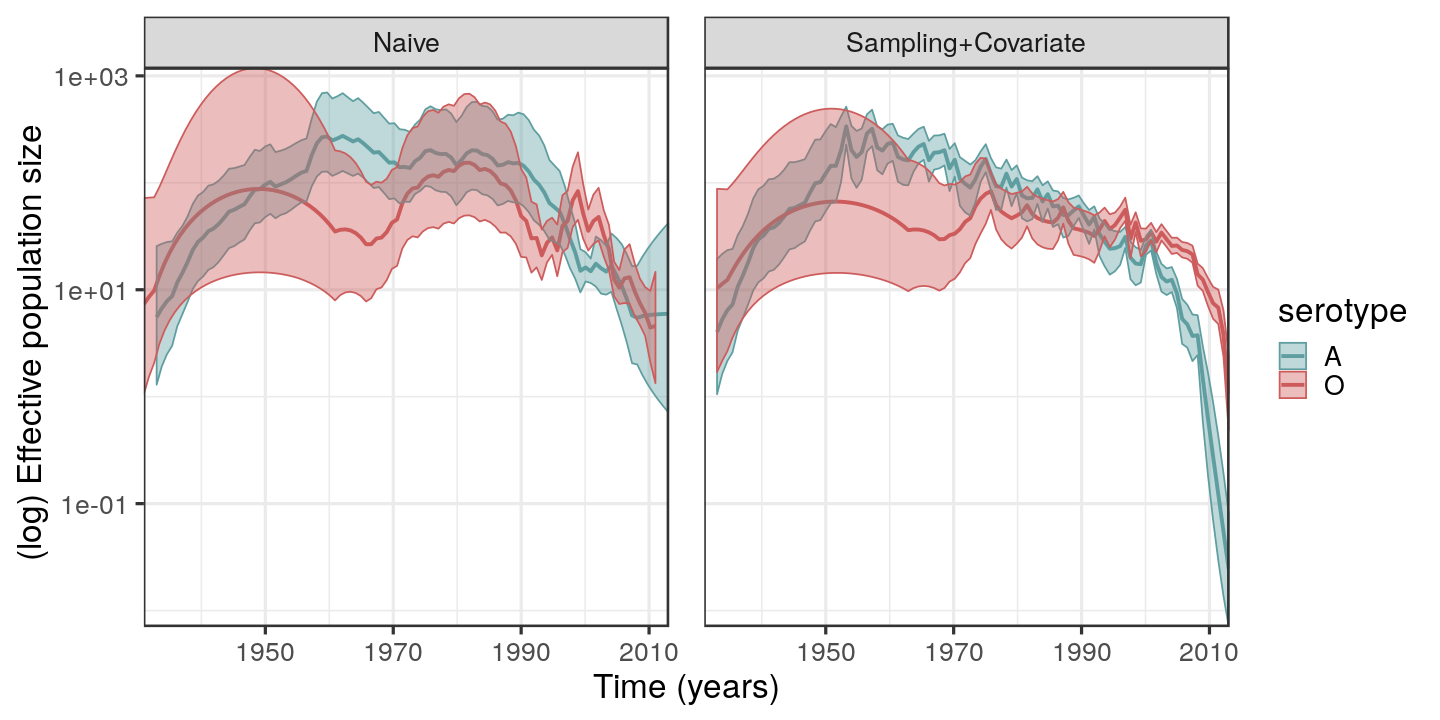

In [168]:
p

In [174]:
ggsave(plot = p, width = 12, height = 6,
       filename = "../../FIGURES/PLOTS/population_size_reconstructions_full.pdf")

In [169]:
p1 <- ggplot(data = subset(FMDV_effpop), aes(x = time, y = median,
                                                         colour = serotype, fill = serotype)) +
    geom_line(size = 1.1) +
    geom_ribbon(aes(ymin = lwr, ymax = upr), alpha = .4) +
    facet_grid(.~method) +
#     geom_line(data = all.cases, size = 1.2,
#              mapping = aes(x = time, y = cases)) + 
    scale_x_continuous("Time (years)", expand = c(0, 0), lim = c(1990, 2013)) +
    scale_y_log10(" (log) Effective population size", expand = c(0, 0)) +
    theme_bw(base_size = 20) +
    theme(panel.spacing.x=unit(1.5, "lines")) +
    scale_colour_manual(values=c("cadetblue", "indianred")) +
    scale_fill_manual(values=c("cadetblue", "indianred")) +
    guides(shape = guide_legend(override.aes = list(size = 3, alpha = 1))) +
NULL

Warning message:
“Removed 142 rows containing missing values (geom_path).”

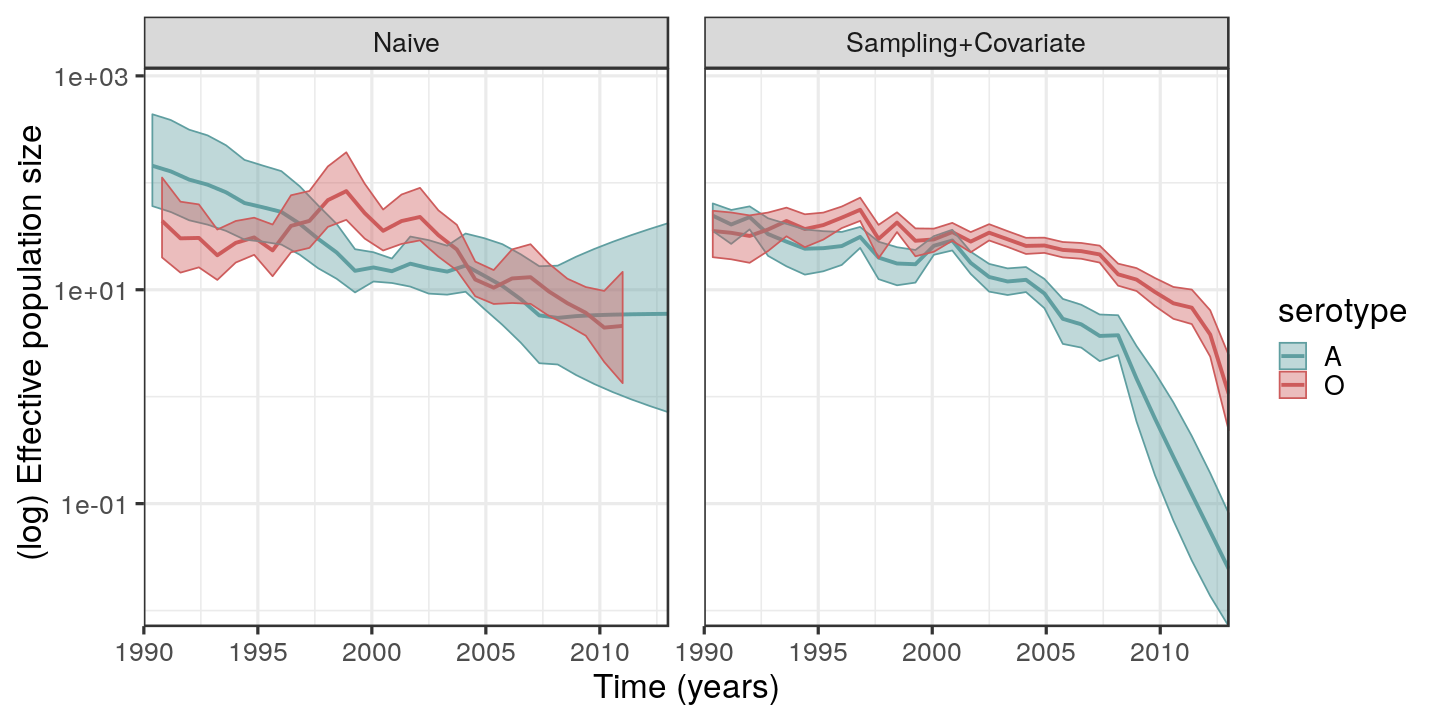

In [170]:
p1

In [173]:
ggsave(plot = p1, width = 12, height = 6,
       filename = "../../FIGURES/PLOTS/population_size_reconstructions_1990s.pdf")

Saving 6.67 x 6.67 in image
Warning message:
“Removed 142 rows containing missing values (geom_path).”